In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import cv2
import yaml
from matplotlib.collections import LineCollection
from tqdm import tqdm
import matplotlib.tri as tri

In [2]:
print(cv2.__version__)

4.5.3


{'image': '133_1.pgm', 'resolution': 0.02, 'origin': [-10.0, -27.92, 0.0], 'negate': 0, 'occupied_thresh': 0.65, 'free_thresh': 0.196}
uint8 (1888, 2272)
0 254


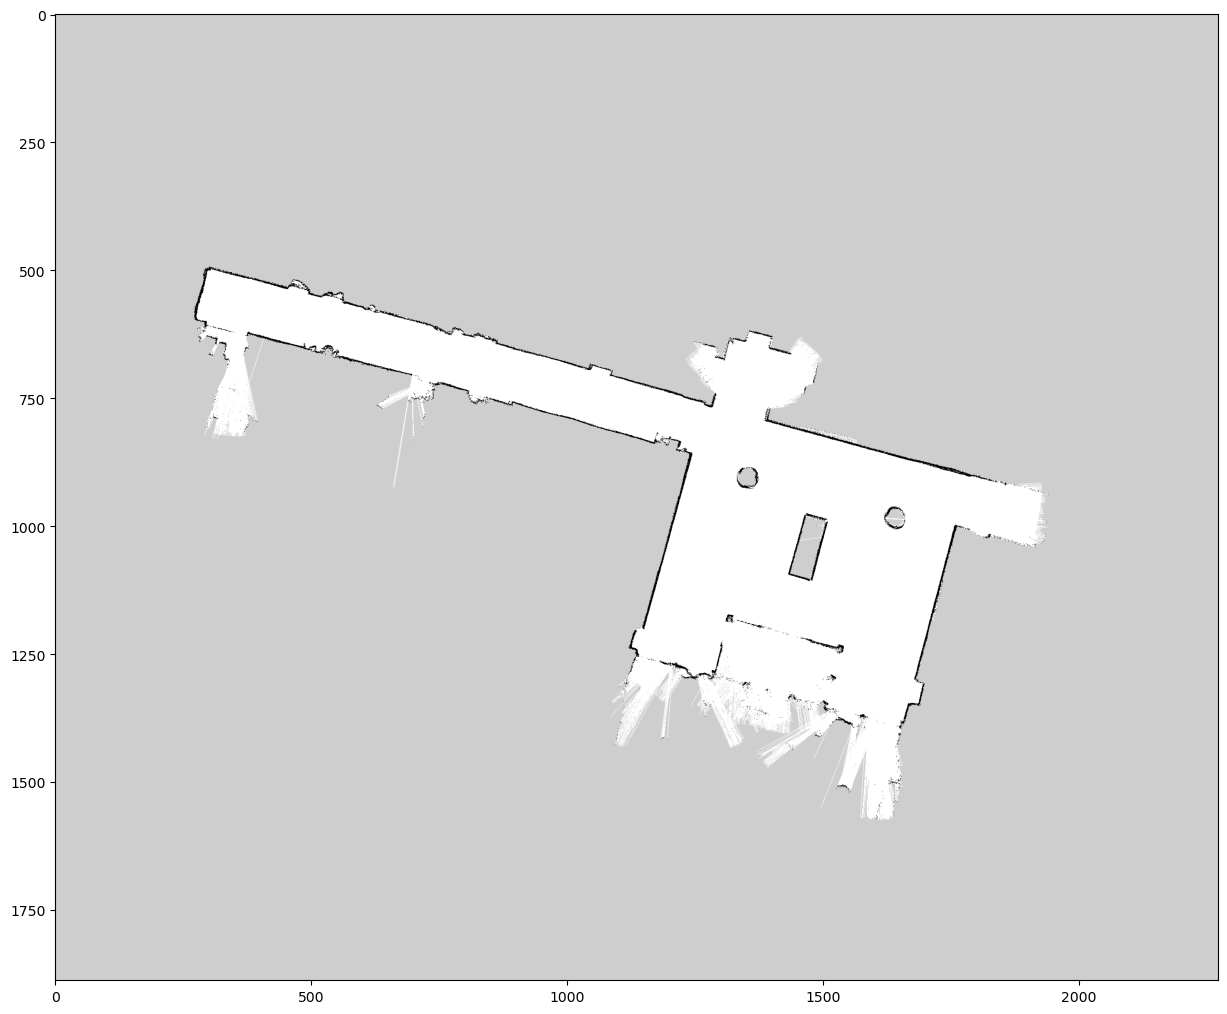

In [5]:
yaml_path = '133_1.yaml'

with open(yaml_path, "r") as y:
    image_format = yaml.safe_load(y)
    print(image_format)

image_path = image_format['image']
# resolution: meters/pixel
resolution = image_format['resolution']
image = cv2.imread(image_path, -1)
print(image.dtype, image.shape)

fig, ax = plt.subplots(figsize=(15, 15))

print(np.min(image), np.max(image))


ax.imshow(image, cmap='gray')

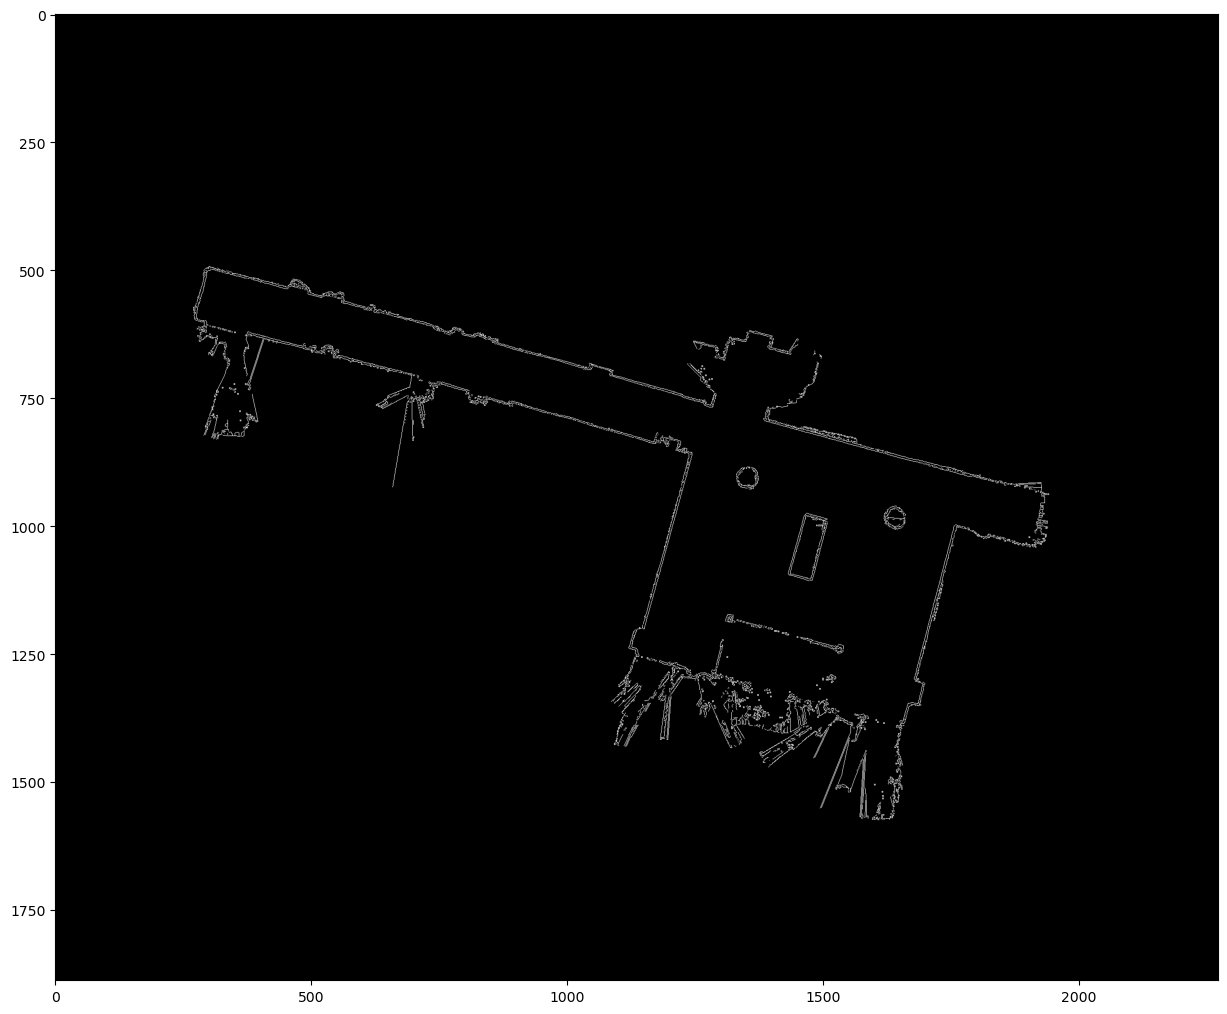

In [4]:

fig, ax = plt.subplots(figsize=(15, 15))

# binary array where 0 denotes black & 255 denotes white

edge_image = cv2.Canny(image, 50, 225)
ax.imshow(edge_image, cmap='gray')

(96, 2)


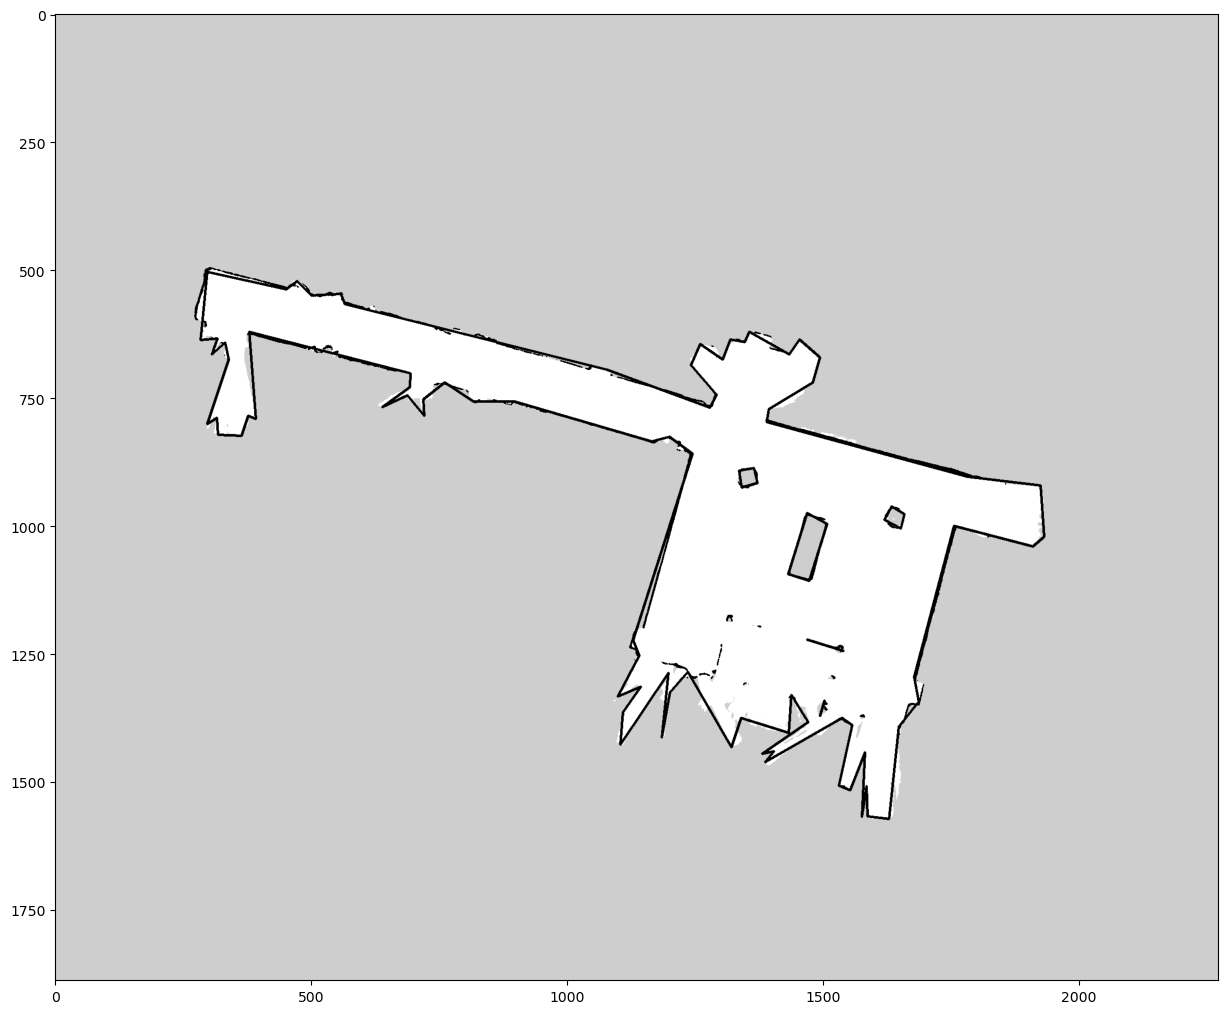

In [6]:
fig, ax = plt.subplots(figsize=(15, 15))

blurred_image = cv2.medianBlur(image, 5, 0)
# ax.imshow(blurred_image, cmap='gray')

_, thresh = cv2.threshold(blurred_image, 250, 255, 0)

# ax.imshow(thresh, cmap='binary')

contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_L1)
# print(contours)

min_area = 400.


contours = [cv2.approxPolyDP(c, epsilon=15, closed=True) for c in contours if cv2.contourArea(c) > min_area]

points = np.squeeze(np.vstack(contours))
print(points.shape)

ax.imshow(cv2.drawContours(blurred_image, contours, -1, (0,255,0), 3), cmap='gray')

In [7]:
def sample_pos(p, v1, v2):
    s = np.random.rand()
    t = np.random.rand()
    in_triangle = s + t <= 1
    return p + s * v1 + t * v2 if in_triangle else p + (1. - s) * v1 + (1. - t) * v2

def area(xs, ys):
    x1, x2, x3 = xs
    y1, y2, y3 = ys
    return .5 * (x1 * y2 + x2 * y3 + x3 * y1 - x2 * y1 - x3 * y2 - x1 * y3)

In [8]:
x_bdry, y_bdry = points[:, 0], points[:, 1]




triang = tri.Triangulation(x_bdry, y_bdry)

x_center = np.rint(x_bdry[triang.triangles].mean(axis=1)).astype(int)
y_center = np.rint(y_bdry[triang.triangles].mean(axis=1)).astype(int)

# print(triang.triangles)

grid_len = 2 * .2 / resolution

print('masking redundant triangles...')
mask = []

v1s = []
v2s = []
ps = []
areas = []
n_triangles = 0
for t in tqdm(triang.triangles):
    # print(t)
    # find grid points inside a triangle
    
    xs, ys = x_bdry[t], y_bdry[t]
    x_min, x_max = np.min(xs), np.max(xs)
    y_min, y_max = np.min(ys), np.max(ys)

    w, h = x_max - x_min, y_max - y_min
    nx, ny = int(w // grid_len) + 1, int(h // grid_len) + 1
    
    x_len = np.rint(np.linspace(x_min, x_max, num=nx, endpoint=True)).astype(int)
    y_len = np.rint(np.linspace(y_min, y_max, num=ny, endpoint=True)).astype(int)
    
    # exclude (potential) vertices
    xv, yv = np.meshgrid(x_len[1:-1], y_len[1:-1])
    
    xv = np.reshape(xv, newshape=(-1,))
    yv = np.reshape(yv, newshape=(-1,))
    p = np.vstack([xv - xs[0], yv - ys[0]])
    v_mat = np.array([[xs[1] - xs[0], xs[2] - xs[0]], [ys[1] - ys[0], ys[2] - ys[0]]])
    barycentric_coord = np.linalg.solve(v_mat, p)
    s, t = barycentric_coord[0], barycentric_coord[1]
    
    inside = (s > 0) & (t > 0) & (s + t < 1)
    
    if np.any(inside):
        # print(inside)
        xv = xv[inside]
        yv = yv[inside]


        # TODO: parallel...?
        contains_free = any([blurred_image[y_pix, x_pix] > 250 for x_pix, y_pix in zip(xv, yv)])
                
        if contains_free:
            v1s.append(np.array([xs[1] - xs[0], ys[1] - ys[0]]))
            v2s.append(np.array([xs[2] - xs[0], ys[2] - ys[0]])) 
            ps.append(np.array([xs[0], ys[0]]))
            areas.append(area(xs, ys))
            mask.append(False)
            n_triangles += 1
        else:
            mask.append(True)
    else:
        mask.append(False)
        v1s.append(np.array([xs[1] - xs[0], ys[1] - ys[0]]))
        v2s.append(np.array([xs[2] - xs[0], ys[2] - ys[0]]))                                     
        ps.append(np.array([xs[0], ys[0]]))
        areas.append(area(xs, ys))
        n_triangles += 1
print(n_triangles)
print(len(areas))
sum_area = sum(areas)

prob_vector = np.array(areas) / sum_area
   
# mask = blurred_image[y_center, x_center] < 250

triang.set_mask(mask)

# fig1, ax1 = plt.subplots()
# ax1.set_aspect('equal')
ax.triplot(triang, color='tab:gray', alpha=0.75)


fig.savefig('triangulation.png')

masking redundant triangles...


100%|███████████████████████████████████████| 178/178 [00:00<00:00, 2945.14it/s]

134
134


254

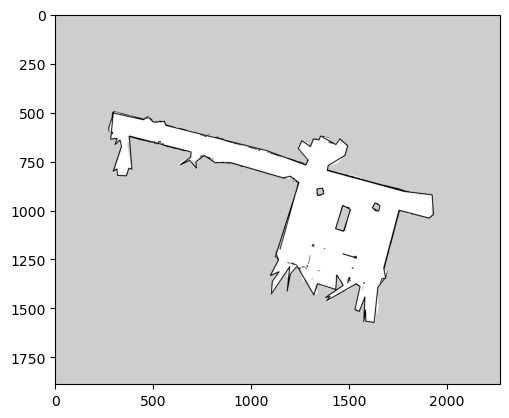

In [9]:
fig, ax = plt.subplots()
ax.imshow(blurred_image, cmap='gray')
blurred_image[1250, 1600]

In [10]:
"""
def coord2pixel(x):
    pixel_coord_x, pixel_coord_y = (x / .02).astype(int)
    return pixel_coord_x, pixel_coord_y
"""

'\ndef coord2pixel(x):\n    pixel_coord_x, pixel_coord_y = (x / .02).astype(int)\n    return pixel_coord_x, pixel_coord_y\n'

In [11]:
def coord2pixel(x):
    return (x / .02).astype(int)

In [12]:
time_step = .1


def diff_drive(q, u):
    # Simulation of \dot{q} = f(q, u) via forward Euler, where time step = 0.1
    a, alpha = u
    _, _, th, v, w = q
    q_dot = np.array([v * np.cos(th), v * np.sin(th), w, a, alpha])
    
    return q + time_step * q_dot

def diff_drive_drft(q):
    _, _, th, v, w = q
    return q + time_step * np.array([v * np.cos(th), v * np.sin(th), w, .0, .0])
    
def diff_drive_sys_vfs(q):
    return time_step * np.array([[.0, .0], [.0, .0], [.0, .0], [1., .0], [.0, 1.]])

In [13]:
class RRT:
    """
    Implementation (possibly not efficient) of RRT. We assume that the system is control-affine.
    """
    def __init__(self,
                 image: np.ndarray,
                 resolution: float,
                 config_space_dim: int,
                 control_input_dim: int,
                 config_space_lower_bound: np.ndarray,
                 config_space_upper_bound: np.ndarray,
                 control_input_lower_bound: np.ndarray,
                 control_input_upper_bound: np.ndarray,
                 simulator: callable,
                 drift_term: callable,
                 system_vector_fields: callable,
                 q_init: np.ndarray,
                 q_goal: np.ndarray,
                 max_size: int
                ):
        """
        image: Image array whose entries range from 0 to 255.
               Any white pixel in the image indicates the free space of the configuration space.
        
        resolution: Resolution of the image (meter/pixel).
        
        config_space_dim: Dimension of the configuration space.
        
        simulator: Function that performs one-step simulation of the system dynamics,.
                   The dynamics is assumed to be control-affine:
                   q_{k+1} = f(q_k) + g(q_k) u_k.
        
        drift_term: Function that computes the drift term of the system: f(q).
        
        system_vector_fields: Function that computes the system vector fields of the system: g(q).
        
        x_init: Inital configuration.
        
        x_goal: Target configuration.
        
        max_size: Maximum number of nodes in the tree.
        
        """
        
        assert config_space_dim > 0
        assert config_space_lower_bound.ndim == config_space_upper_bound.ndim == 1
        assert config_space_dim == config_space_lower_bound.size
        assert q_init.ndim == q_goal.ndim == 1
        assert config_space_dim == q_init.size
        assert np.all(config_space_lower_bound < config_space_upper_bound)
        assert np.all(control_input_lower_bound < control_input_upper_bound)
        assert max_size > 0
        
        self._qdim = config_space_dim
        self._udim = control_input_dim
        
        self._qlb = config_space_lower_bound
        self._qub = config_space_upper_bound
        
        self._ulb = control_input_lower_bound
        self._uub = control_input_upper_bound
        
        self._sim = simulator
        
        self._drift = drift_term
        self._sys_vs = system_vector_fields
        
        
        # image array whose entries range from 0 to 255
        self._image = image
        self._image_height, self._image_width = image.shape
        self._resolution = resolution
        
        # scaled image (so that all entries take values in [0, 1))
        self._normalized_image = image.astype(np.float32) / 255.
        
        self._candidates = []
        
        # initialization of a tree
        self._root = 0
        self._nodes = [self._root]
        # self._qs = {self._root: q_init}
        
        # initialization
        self._qs = np.zeros((max_size, config_space_dim))
        self._qs[0] = q_init
        self._q_init =q_init

        # child nodes of each node
        self._children = {self._root: []}
        self._q_goal = q_goal

        self._next_node = 1
        
        # weights used to compute the distance between to configurations
        # TODO: move this to __init__
        self._weights = np.array([1., 1., .1, .1, .1])
        
        self._max_sz = max_size

        self._compile_qp_solver()
        
        return
    
    def _compile_qp_solver(self):
        # quadratic programming formulation
        # CVXPY used here since I am not sure if I can get a Gurobi license for Jackal...
        self._u_var = cp.Variable(self._udim)
        self._q_param = cp.Parameter(self._qdim, nonneg=False, name='q')
        self._drift_param = cp.Parameter(self._qdim, nonneg=False, name='drift')
        self._sys_vs_param = cp.Parameter((self._qdim, self._udim), nonneg=False, name='system vector fields')
    
        q_next = self._drift_param + self._sys_vs_param @ self._u_var
        objective = cp.Minimize(cp.sum(cp.multiply(self._weights, cp.square(q_next - self._q_param))))
        constraints = [self._qlb <= q_next, q_next <= self._qub, self._ulb <= self._u_var, self._u_var <= self._uub]
        self._prob = cp.Problem(objective, constraints)
        return
        
    def _solve_qp(self, q, drift, sys_vs):
        self._q_param.value = q
        self._drift_param.value = drift
        self._sys_vs_param.value = sys_vs
        
        self._prob.solve(verbose=False)
        return self._u_var.value
        
    
    def _nearest(self, q) -> int:
        """
        Implementation of naive nearest neighbor search.
        """
        # TODO: approximate nearest neighbor & corresponding data structure
        qs = self._qs[self._nodes]
        squared_distance = np.sum(self._weights * (q - qs) ** 2, axis=1)
        nearest = self._nodes[np.argmin(squared_distance)]

        return nearest
        

    def expand(self, q):
        
        if self._in_free_space(q):
            
            nearest = self._nearest(q)
            q_nearest = self._qs[nearest]


            drift = self._drift(q_nearest)
            sys_vs = self._sys_vs(q_nearest)
            
            """
            
            u_var = cp.Variable(self._udim)
            q_next = drift + sys_vs @ u_var
            objective = cp.Minimize(cp.sum(cp.multiply(self._weights, cp.square(q_next - q))))
            constraints = [self._qlb <= q_next, q_next <= self._qub, self._ulb <= u_var, u_var <= self._uub]
            prob = cp.Problem(objective, constraints)

            result = prob.solve(verbose=False)
            u = u_var.value
            """
            
            u = self._solve_qp(q, drift, sys_vs)
            
            q_leaf = self._sim(q_nearest, u)
            # print(w_val)
            # print(x, x_leaf)

            # self._candidates.append(x_leaf)

            if self._in_free_space(q_leaf) and not self._collide(q_leaf, q_nearest):
                
                node_to_be_added = self._next_node
                self._nodes.append(node_to_be_added)
                self._children[node_to_be_added] = []
                # self._qs[node_to_be_added] = q_leaf
                self._qs[node_to_be_added] = q_leaf
                self._children[nearest].append(node_to_be_added)
                self._next_node += 1
        return
        
    def _in_free_space(self, q) -> bool:
        
        window_size = int(.4 / self._resolution) + 1
        
        col_idx, row_idx = coord2pixel(q[:2])
        
        
        left, right = max(0, col_idx - window_size), min(col_idx + window_size + 1, self._image_width)
        top, bottom = max(0, row_idx - window_size), min(row_idx + window_size + 1, self._image_height)
        
        # small box around the given position
        fragment = self._normalized_image[top:bottom, left:right]
        
        # probability of the box region being included in the free space
        free_prob = np.min(fragment)
                      
        return free_prob > .96

        
        
    def _collide(self, q1, q2) -> bool:
        """
        approximately check if a collision  occurs between a line segment and the obstacle space 
        only midpoint of the configurations verified
        """
        q_inner = .5 * (q1 + q2)
        return not self._in_free_space(q_inner)
        
    
    def size(self):
        return self._next_node
    
    def draw(self, filename='example.png'):
        
        """
        Visualization of the tree on the planar region (image in this case).
        """
        plt.clf(), plt.cla()
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.imshow(self._image, cmap='gray')

        # gather the nodes & edges of the planar tree
        
        # vertices
        vertices = coord2pixel(self._qs[:, :2])
        # ax.scatter(vertices[:, 0], vertices[:, 1], marker='o', s=20, color='k')
        
        
        # edges
        edges = []
        for node in self._nodes:
            q_pa = self._qs[node]

            for child_node in self._children[node]:
                q_child = self._qs[child_node]
                e = np.array([q_pa[:2], q_child[:2]])
                edges.append(e)
                
        edges = [coord2pixel(e) for e in edges]

        line_segments = LineCollection(edges, colors='k', linestyles='solid', linewidths=2)
        
        ax.add_collection(line_segments)
        
        # task space lower & upper bound
        ax.axhline(y=self._qlb[1] / self._resolution, color='k', linestyle='dotted')
        ax.axhline(y=self._qub[1] / self._resolution, color='k', linestyle='dotted')
        ax.axvline(x=self._qlb[0] / self._resolution, color='k', linestyle='dotted')
        ax.axvline(x=self._qub[0] / self._resolution, color='k', linestyle='dotted')
        
        # visualize inital & goal configuration
        q_init = self._q_init
        q_goal = self._q_goal
        ax.scatter(q_init[0] / self._resolution, q_init[1] / self._resolution, marker='s', s=80, color='tab:red', label='start', zorder=5)
        ax.scatter(self._q_goal[0] / self._resolution, self._q_goal[1] / self._resolution, marker='s', s=80, color='tab:blue', label='goal', zorder=5)
        ax.legend(fontsize=18)
        fig.tight_layout()
        # fig.savefig(filename, dpi=120)
        return fig, ax

100%|██████████████████████████████████| 500000/500000 [43:43<00:00, 190.59it/s]


tree size: 178688


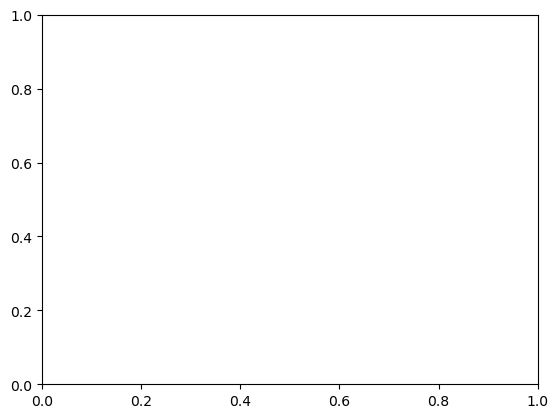

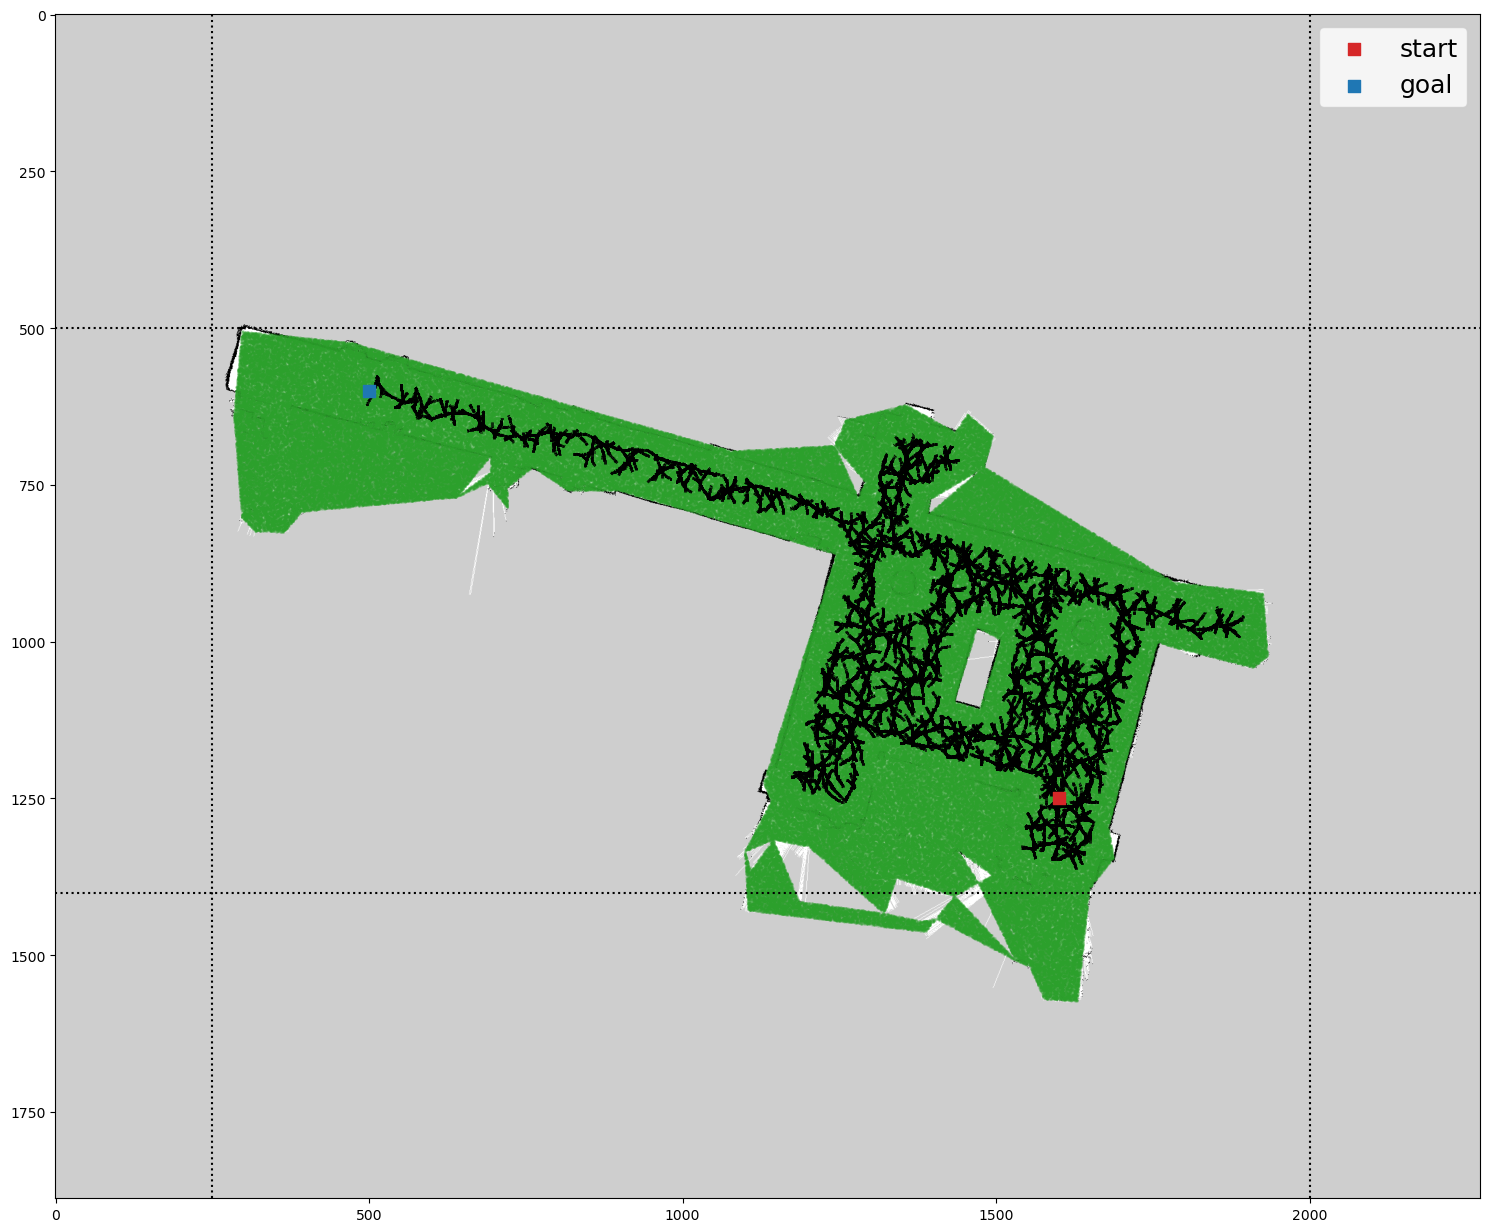

In [16]:


cspace_dim = 5
ctrl_dim = 2


cspace_lb = np.array([5., 10., -np.pi, -.5, -.7])
cspace_ub = np.array([40., 28., np.pi, .5, .7])

ctrl_lb = np.array([-1., -2.])
ctrl_ub = np.array([1., 2.])



q_init = np.array([32., 25., np.pi / 2., .0, .0])
q_goal = np.array([10., 12., .9 * np.pi, .0, .0])


max_size = 500000

tree = RRT(image=image,
           resolution=.02,
           config_space_dim=cspace_dim,
           control_input_dim=ctrl_dim,
           config_space_lower_bound=cspace_lb,
           config_space_upper_bound=cspace_ub,
           control_input_lower_bound=ctrl_lb,
           control_input_upper_bound=ctrl_ub,
           simulator=diff_drive,
           drift_term=diff_drive_drft,
           system_vector_fields=diff_drive_sys_vfs,
           q_init=q_init,
           q_goal=q_goal,
           max_size=max_size
          )

# TODO: sampling from the free task space via triangulation
q_rand = cspace_lb + (cspace_ub - cspace_lb) * np.random.rand(max_size, cspace_dim)
idxs = np.random.choice(n_triangles, size=max_size, p=prob_vector)

x_list = []
y_list = []

# print(n_triangles)
# TODO: parallel (simultaneously sample barycentric coordinates)
for i in tqdm(range(max_size)):
    idx = idxs[i]
    p, v1, v2 = ps[idx], v1s[idx], v2s[idx]
    xy = .02 * sample_pos(p, v1, v2)
    x_list.append(xy[0] / resolution)
    y_list.append(xy[1] / resolution)
    
    q = q_rand[i]
    q[:2] = xy
    # assert np.all(q <= cspace_ub) and np.all(cspace_lb <= q)
    
    # print(x)
    tree.expand(q)
print('tree size:', tree.size())
fig, ax = tree.draw()
ax.scatter(x_list, y_list, color='tab:green', s=1, alpha=0.2)

In [54]:
fig.savefig('rrt_example.png')